In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras 
import sys
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv(r"../../Dataset/NCA Preprocessed/master_features_nca.csv")
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [3]:
import sys
sys.path.append("../../")
from preprocessing.data_preprocessor import DataPreprocessor


preprocessor = DataPreprocessor(
    train_size=0.8,
    ic_low=0,
    ic_high=20
)

data = preprocessor.preprocess(df)

X_ic_train = data["X_ic_train"]
X_context_train = data["X_context_train"]
y_train = data["y_train"]


print("Train Data shape:")
print("X_ic_train shape:", X_ic_train.shape)
print("X_context_train shape:", X_context_train.shape)
print("y_train shape:",y_train.shape)


Train Data shape:
X_ic_train shape: (18109, 20, 1)
X_context_train shape: (18109, 7)
y_train shape: (18109,)


__FGSM ATTACK__

In [4]:
def fgsm_attack(model, X_ic_test, X_context_test, y_test, epsilon = 0.05):
    X_ic_adv = tf.convert_to_tensor(X_ic_test)
    X_context_test = tf.convert_to_tensor(X_context_test)
    y_true = tf.convert_to_tensor(y_test)
    
    with tf.GradientTape() as tape:
        tape.watch(X_ic_adv)
        y_pred = model([X_ic_adv, X_context_test],training=False)
        loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)

    gradient = tape.gradient(loss, X_ic_adv)
    signed_grad = tf.sign(gradient)
    X_ic_adv = X_ic_adv + epsilon * signed_grad

    return X_ic_adv.numpy()


__Model Metrics__

In [ ]:
def attack_eval(
    model,
    X_ic_test,
    X_context_test,
    y_test_norm,
    y_std,
    y_mean,
    epsilon,
    attack_fn,
    model_name="",
    plot=True
):
    # Generate adversarial samples
    X_ic_test_adv = attack_fn(
        model,
        X_ic_test,
        X_context_test,
        y_test_norm,
        epsilon
    )

    # Predictions (normalized)
    y_pred_norm = model.predict([X_ic_test, X_context_test], verbose=0).flatten()
    y_pred_adv_norm = model.predict([X_ic_test_adv, X_context_test], verbose=0).flatten()

    # Inverse scaling (REAL SOH)
    y_test = y_test_norm * y_std + y_mean
    y_pred = y_pred_norm * y_std + y_mean
    y_pred_adv = y_pred_adv_norm * y_std + y_mean

    # Metrics
    mae_clean = mean_absolute_error(y_test, y_pred)
    mae_adv = mean_absolute_error(y_test, y_pred_adv)
    delta_mae = mae_adv - mae_clean

    mape_clean = mean_absolute_percentage_error(y_test, y_pred)
    mape_adv = mean_absolute_percentage_error(y_test, y_pred_adv)

    # Optional plots
    if plot:
        plt.figure(figsize=(16,6))

        plt.subplot(1,2,1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], "r--")
        plt.title(f"{model_name} - Clean ")
        plt.xlabel("True SOH")
        plt.ylabel("Predicted SOH")
        plt.grid()

        plt.subplot(1,2,2)
        plt.scatter(y_test, y_pred_adv, alpha=0.5, color="orange")
        plt.plot([min_val, max_val], [min_val, max_val], "r--")
        plt.title(f"{model_name} - Attacked (ε={epsilon})")
        plt.xlabel("True SOH")
        plt.ylabel("Predicted SOH")
        plt.grid()

        plt.show()

    return {
        "MAE_clean": mae_clean,
        "MAE_adv": mae_adv,
        "ΔMAE": delta_mae,
        "MAPE_clean": mape_clean,
        "MAPE_adv": mape_adv
    }

In [6]:
from tabulate import tabulate

def run_attack_evaluation(
    model,
    model_name,
    attack_fn,
    X_ic_test,
    X_context_test,
    y_test_norm,
    y_std,
    y_mean,
    eps_values,
    plot=False
):
    """
    Runs adversarial attack evaluation for a given model
    and prints results in tabular form.
    """

    results = []

    for eps in eps_values:
        res = attack_eval(
            model=model,
            X_ic_test=X_ic_test,
            X_context_test=X_context_test,
            y_test_norm=y_test_norm,
            y_std=y_std,
            y_mean=y_mean,
            epsilon=eps,
            attack_fn=attack_fn,
            model_name=model_name,
            plot=plot
        )

        results.append([
            eps,
            res["MAE_clean"],
            res["MAE_adv"],
            res["ΔMAE"],
            res["MAPE_clean"],
            res["MAPE_adv"]
        ])

    headers = [
        "Epsilon",
        "MAE (Clean)",
        "MAE (Attacked)",
        "ΔMAE",
        "MAPE (Clean)",
        "MAPE (Attacked)"
    ]

    print(f"\nAdversarial Evaluation Results – {model_name}")
    print(tabulate(results, headers=headers, floatfmt=".4f"))

    return results

In [7]:
X_ic_test = data['X_ic_test']
X_context_test = data['X_context_test']
y_test = data['y_test']

y_mean = data['y_mean']
y_std = data['y_std']

print("Test data shape:")
print("X_ic_test shape:", X_ic_test.shape)
print("X_context_test shape:", X_context_test.shape)
print("Y_test shape:", y_test.shape)

Test data shape:
X_ic_test shape: (4528, 20, 1)
X_context_test shape: (4528, 7)
Y_test shape: (4528,)


__CNN + LSTM__

----------
CNN + LSTM
----------


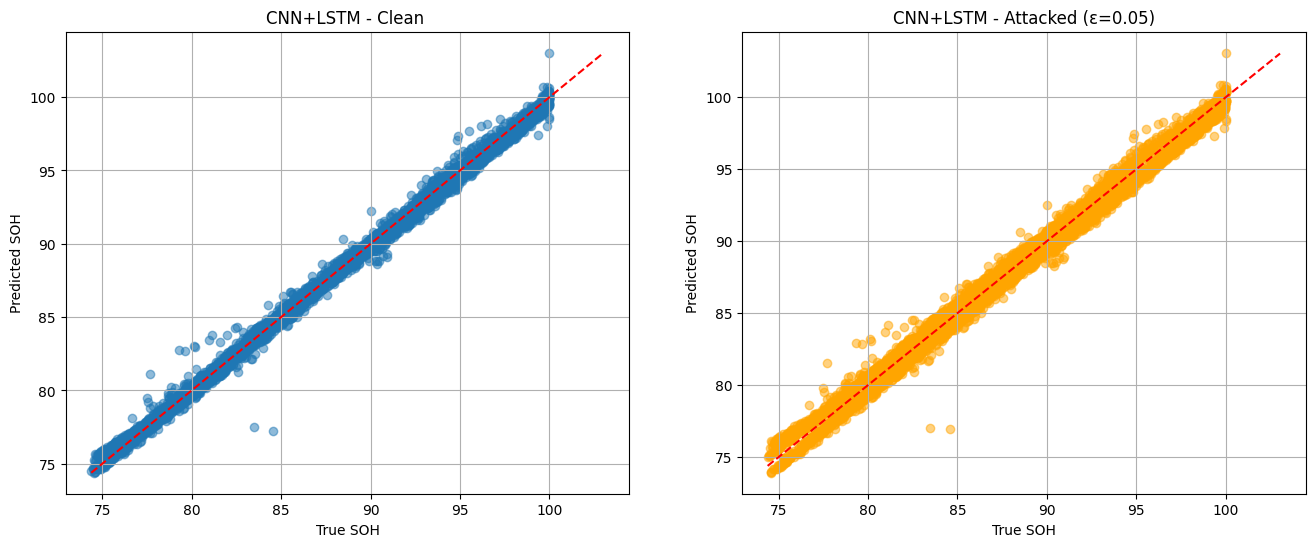

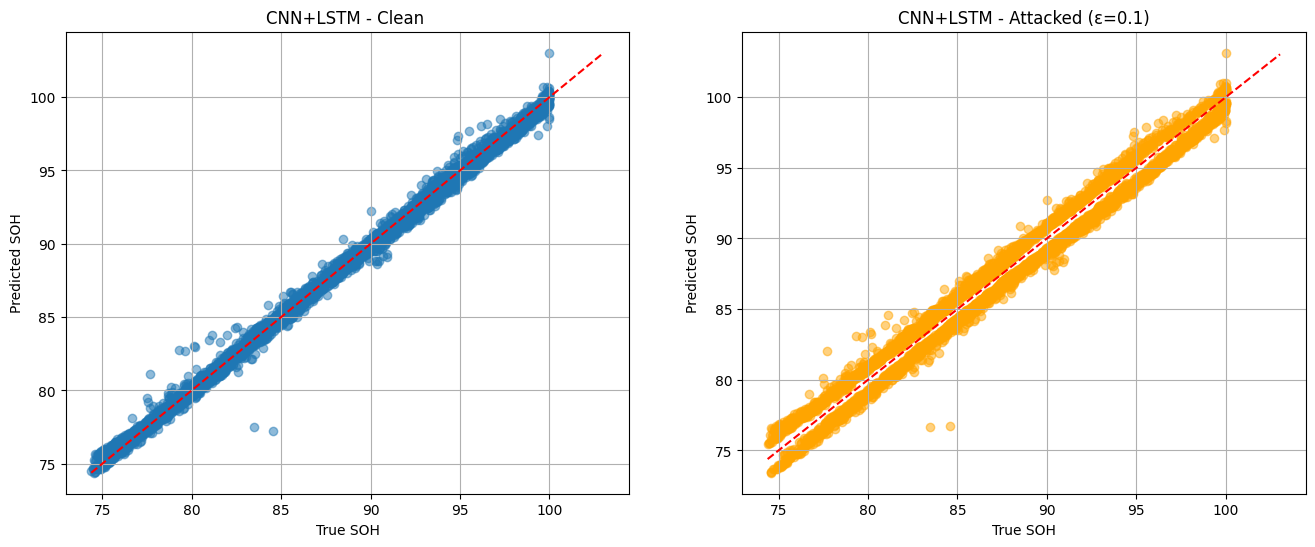

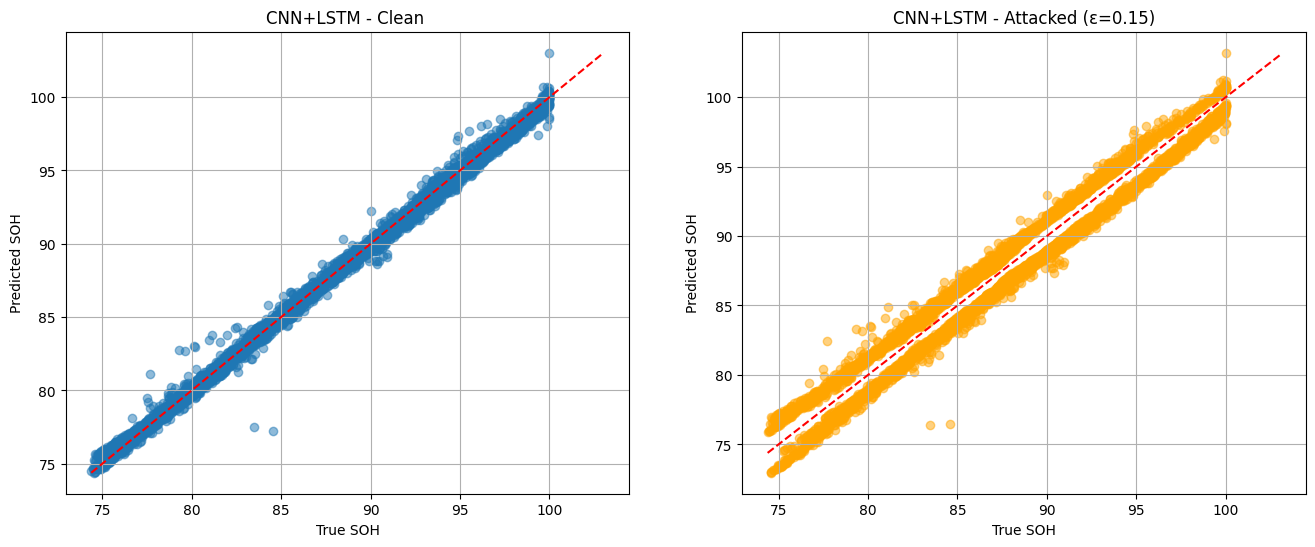


Adversarial Evaluation Results – CNN+LSTM
  Epsilon    MAE (Clean)    MAE (Attacked)    ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  ------  --------------  -----------------
   0.0500         0.2907            0.6151  0.3244          0.0033             0.0071
   0.1000         0.2907            0.9277  0.6371          0.0033             0.0108
   0.1500         0.2907            1.2271  0.9365          0.0033             0.0143


In [ ]:
print("----------")
print("CNN + LSTM")
print("----------")

cnn_lstm = keras.models.load_model(r"../../Models/best_cnn_lstm.keras")

eps_values = [0.05, 0.10, 0.15]

results_cnn_lstm = run_attack_evaluation(
    model=cnn_lstm,
    model_name="CNN+LSTM",
    attack_fn=fgsm_attack,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=eps_values,
    plot=True   # True only when you want plots
)

__CNN + GRU__

CNN + GRU


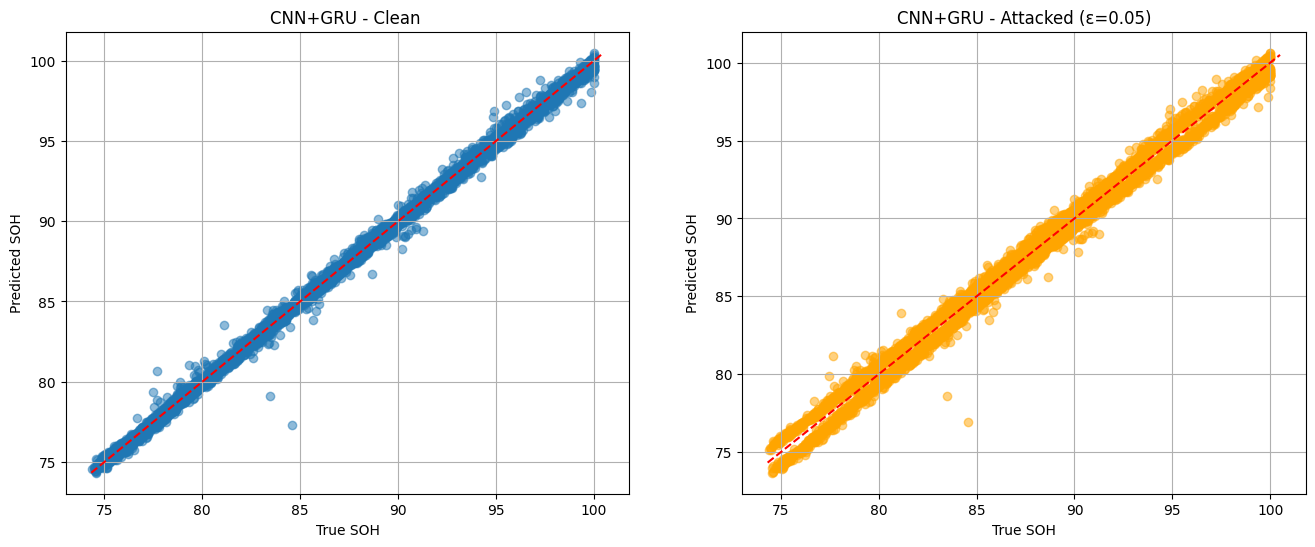

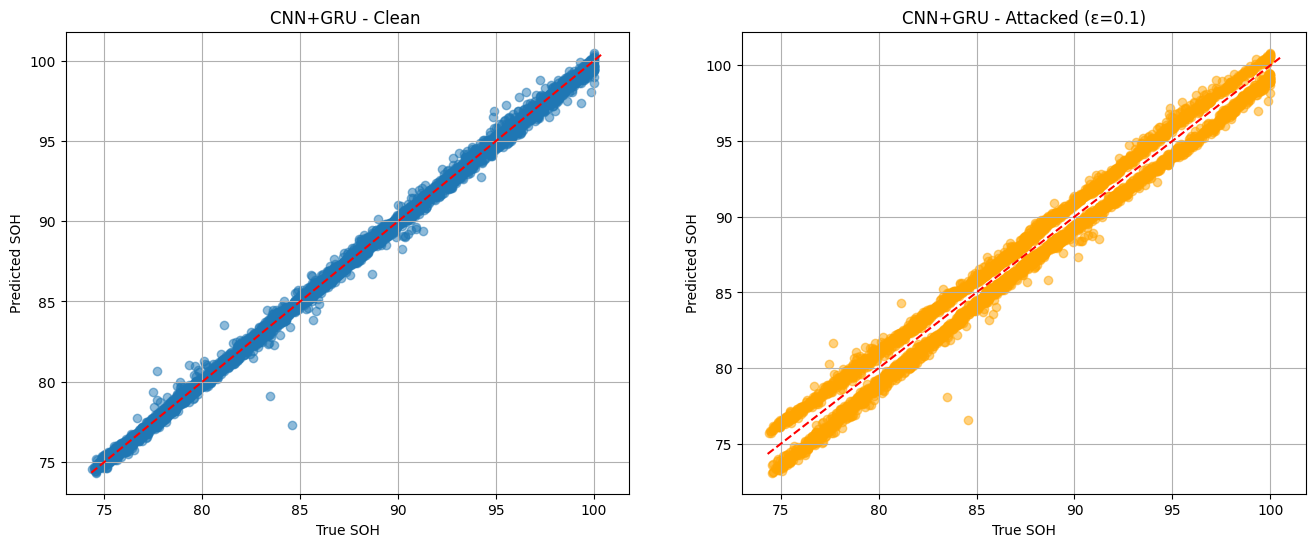

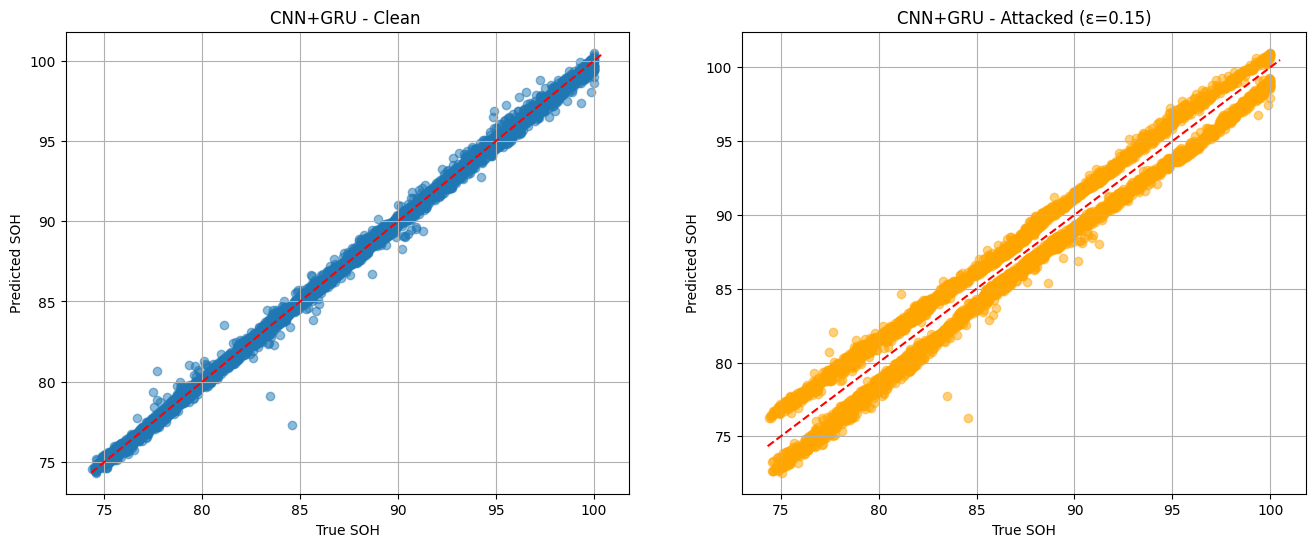


Adversarial Evaluation Results – CNN+GRU
  Epsilon    MAE (Clean)    MAE (Attacked)    ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  ------  --------------  -----------------
   0.0500         0.2326            0.6110  0.3784          0.0027             0.0071
   0.1000         0.2326            0.9666  0.7339          0.0027             0.0113
   0.1500         0.2326            1.3019  1.0692          0.0027             0.0152


In [9]:
print("CNN + GRU")
cnn_gru = keras.models.load_model(r"../../Models/best_cnn_gru.keras")

results_cnn_gru = run_attack_evaluation(
    model=cnn_gru,
    model_name="CNN+GRU",
    attack_fn=fgsm_attack,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=eps_values,
    plot=True   # True only when you want plots
)

__RCN__

---
RCN
---


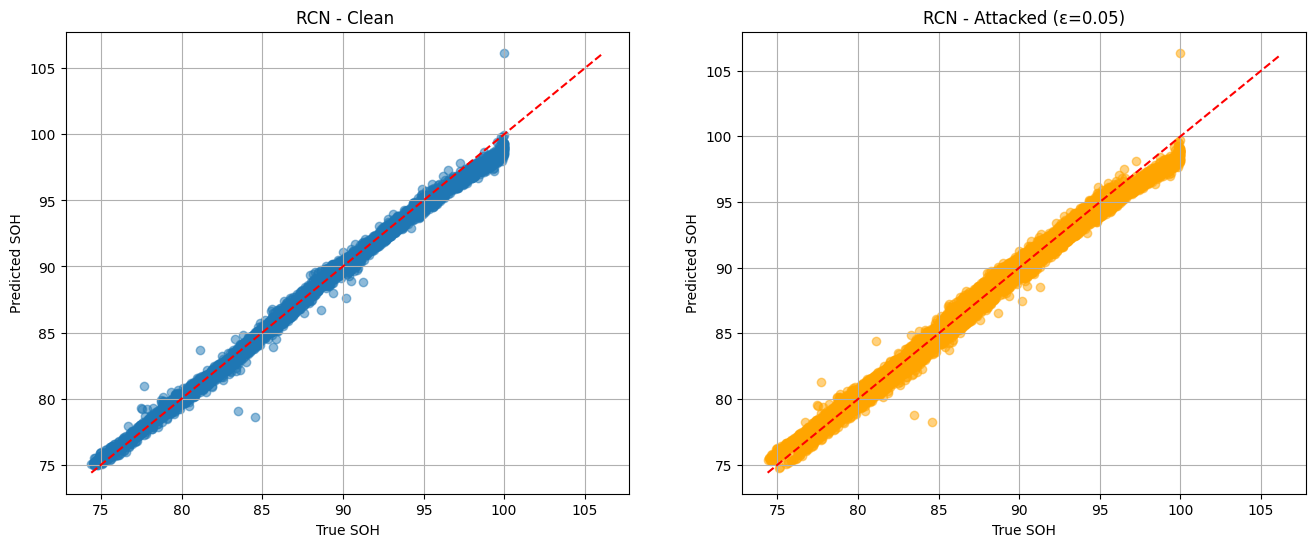

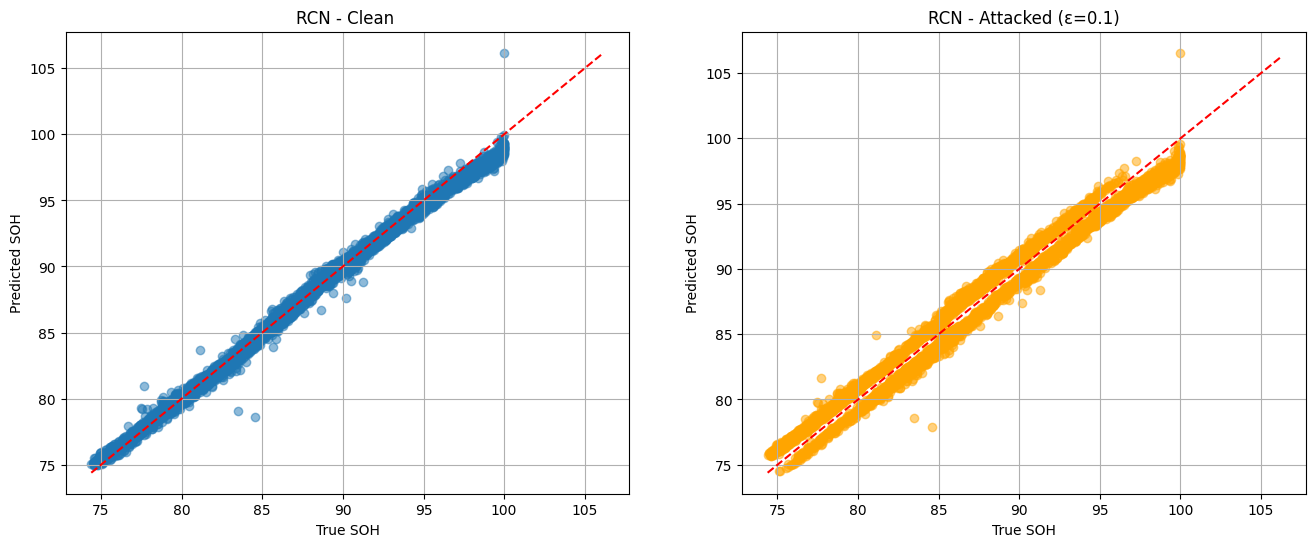

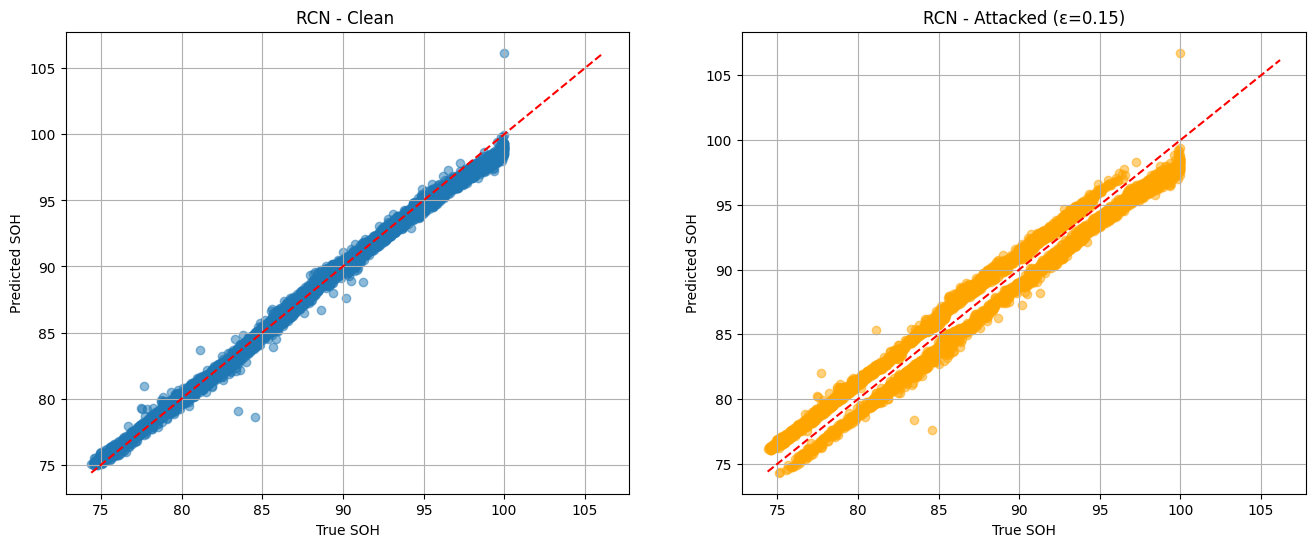


Adversarial Evaluation Results – RCN
  Epsilon    MAE (Clean)    MAE (Attacked)    ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  ------  --------------  -----------------
   0.0500         0.3568            0.6960  0.3392          0.0040             0.0079
   0.1000         0.3568            1.0117  0.6549          0.0040             0.0116
   0.1500         0.3568            1.3012  0.9444          0.0040             0.0150


In [10]:
print("---")
print("RCN")
print("---")

rcn = keras.models.load_model(r"../../Models/best_rcn.keras")

results_rcn = run_attack_evaluation(
    model=rcn,
    model_name="RCN",
    attack_fn=fgsm_attack,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=eps_values,
    plot=True   # True only when you want plots
)

__CNN__

---
CNN
---


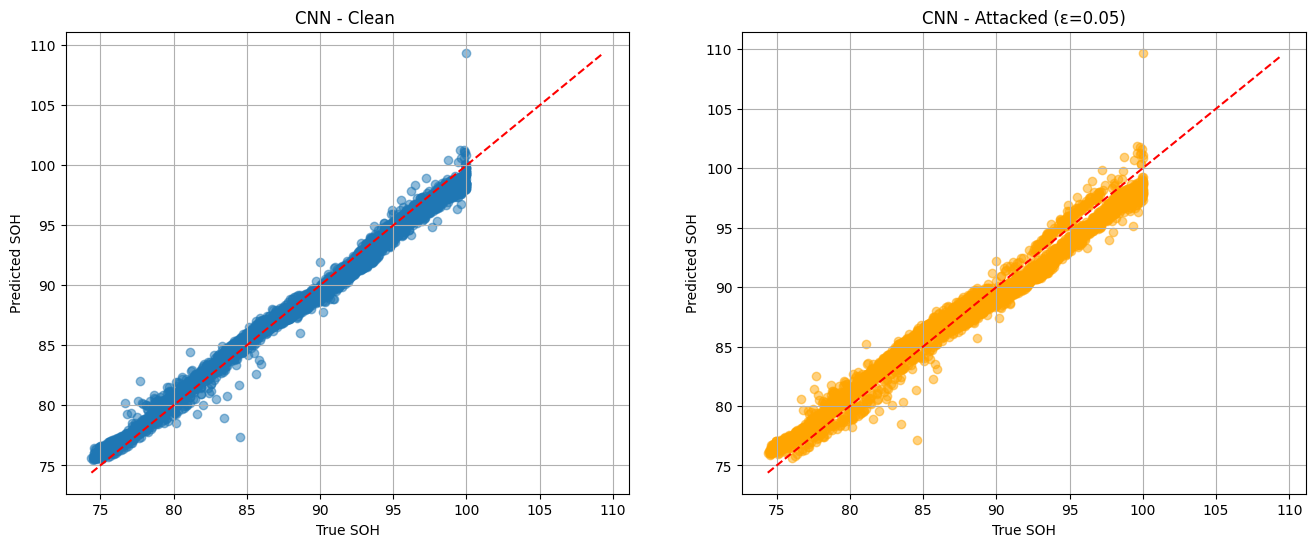

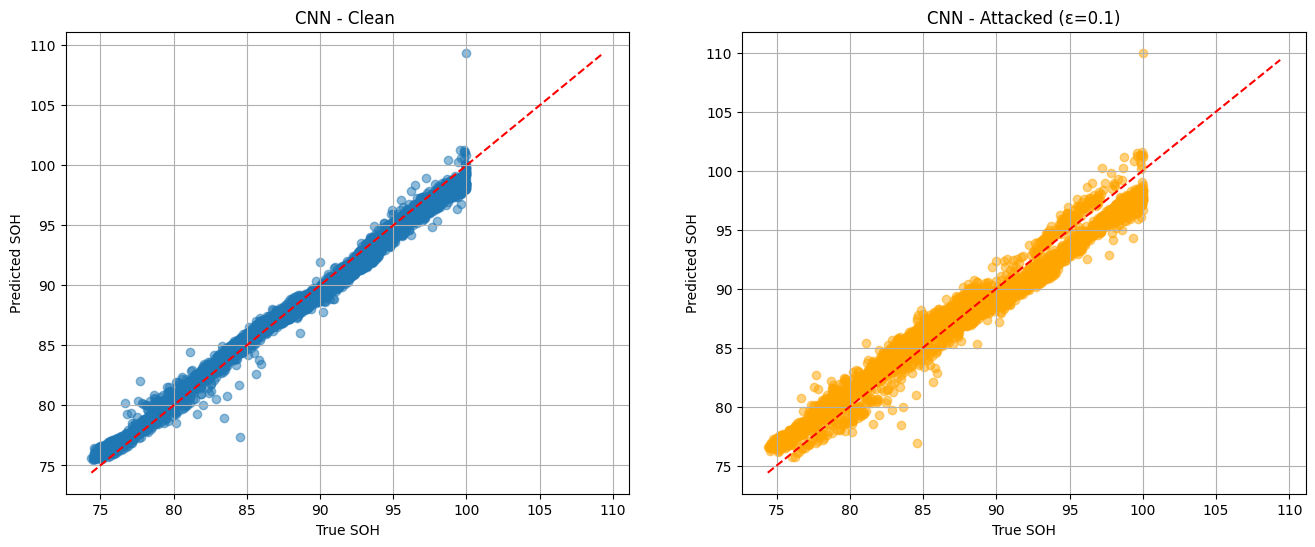

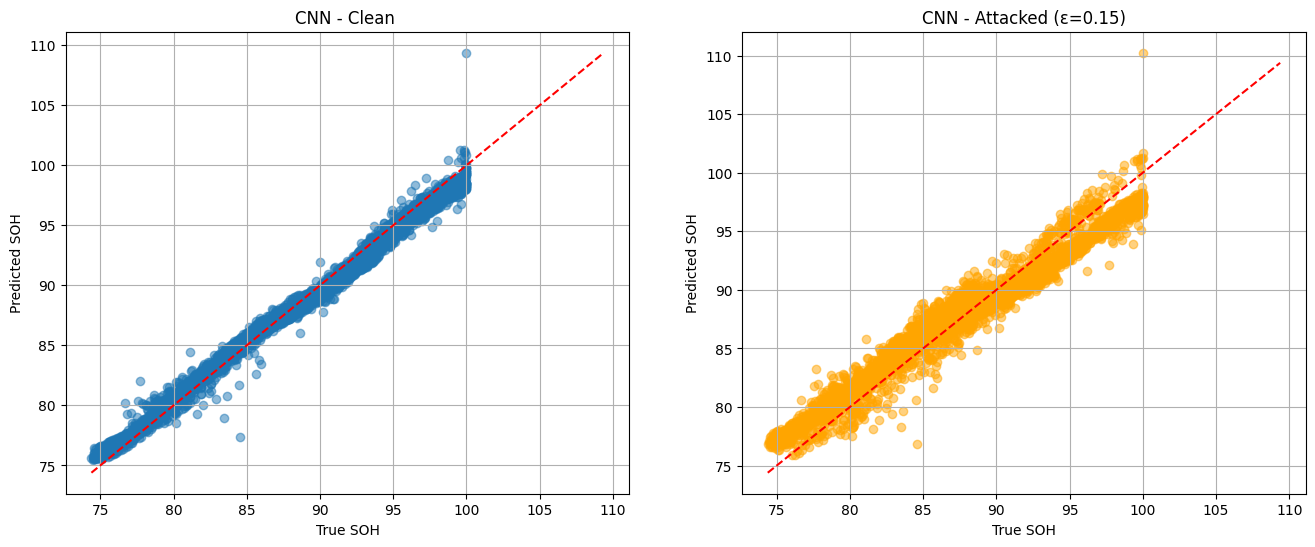


Adversarial Evaluation Results – CNN
  Epsilon    MAE (Clean)    MAE (Attacked)    ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  ------  --------------  -----------------
   0.0500         0.5967            1.0972  0.5005          0.0068             0.0126
   0.1000         0.5967            1.2727  0.6760          0.0068             0.0147
   0.1500         0.5967            1.3532  0.7565          0.0068             0.0156


In [11]:
print("---")
print("CNN")
print("---")

cnn = keras.models.load_model(r"../../Models/best_cnn.keras")

results_cnn = run_attack_evaluation(
    model=cnn,
    model_name="CNN",
    attack_fn=fgsm_attack,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=eps_values,
    plot=True   # True only when you want plots
)

In [12]:
idx = 100   
epsilon = 0.1
orig_ic = X_ic_test[idx].reshape(-1)     
orig_ctx = X_context_test[idx].reshape(1,-1)
orig_true = y_test[idx]

adv_ic = fgsm_attack(
    cnn_gru,
    X_ic_test[idx:idx+1],     
    X_context_test[idx:idx+1],
    y_test[idx:idx+1],
    epsilon = 0.1
)

adv_ic = adv_ic.reshape(-1)

y_pred_orig = cnn_gru.predict([X_ic_test[idx:idx+1], X_context_test[idx:idx+1]], verbose=0)[0][0]
y_pred_adv  = cnn_gru.predict([adv_ic.reshape(1,-1,1), X_context_test[idx:idx+1]], verbose=0)[0][0]

y_pred_orig = y_pred_orig * y_std + y_mean
y_pred_adv = y_pred_adv * y_std + y_mean

orig_true = orig_true * y_std + y_mean

print("Original pred:", y_pred_orig)
print("Adversarial pred:", y_pred_adv)
print("True value:", orig_true)

Original pred: 86.12362844103282
Adversarial pred: 85.57571181995344
True value: 86.45


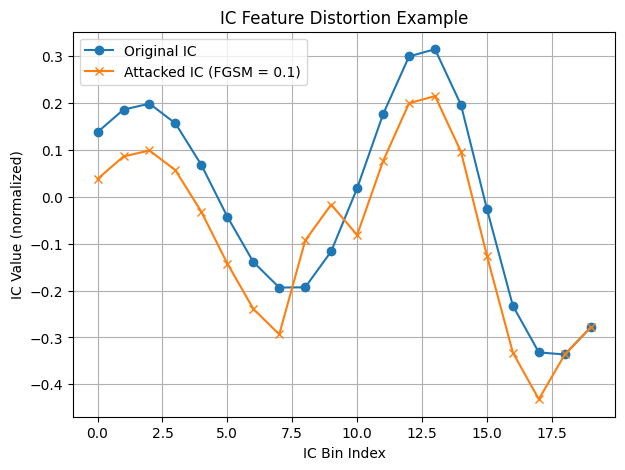

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(orig_ic, marker='o', label="Original IC")
plt.plot(adv_ic, marker='x', label=f"Attacked IC (FGSM = {epsilon})")
plt.title("IC Feature Distortion Example")
plt.xlabel("IC Bin Index")
plt.ylabel("IC Value (normalized)")
plt.legend()
plt.grid(True)
plt.show()
